For OED in the batch design setting, in cases where the likelihood models remain unchanged for each design, computing EIG on a grid becomes expensive as the batch size grows. In such cases, if we resort to methods like Bayesian Optimization for interpolating between limited EIG evaluations, it may be a good idea to enforce permutation invariance for the Gaussian Process, in its kernel function. One simple way to do this is via Haar scattering [https://arxiv.org/pdf/1406.2390]:

$$(\alpha, \beta) \to (\alpha + \beta, |\alpha - \beta| )$$

In [28]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from oed_with_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
def model_2(theta, d):
    d1 = d[:, 0:1]
    d2 = d[:, 1:2]
    return np.c_[theta ** 3 * d1 ** 2 + theta * np.exp(-np.abs(0.2 - d1)),
                 theta ** 3 * d2 ** 2 + theta * np.exp(-np.abs(0.2 - d2))]

In [30]:
n_param = 1 # Number of parameters.
n_design = 2 # Number of design variables.
n_obs = 2 # Number of observations.

low = 0
high = 1
prior_rvs = lambda n_sample: np.random.uniform(low=low,
                                               high=high,
                                               size=(n_sample, n_param))
prior_logpdf = lambda theta: uniform_logpdf(theta,
                                            low=low,
                                            high=high)

design_bounds = [(0, 1), (0, 1)] # lower and upper bounds of design variables.

# Noise if following N(noise_loc, noise_base_scale + noise_ratio_scale * abs(G))
noise_loc = 0
noise_base_scale = 0.01
noise_ratio_scale = 0
noise_info = [(noise_loc, noise_base_scale, noise_ratio_scale),
              (noise_loc, noise_base_scale, noise_ratio_scale)]

# Random state could be eith an integer or None.
random_state = 2021

In [31]:
oed_2 = OED(model_fun=model_2,
            n_param=n_param,
            n_design=n_design,
            n_obs=n_obs,
            prior_rvs=prior_rvs,
            design_bounds=design_bounds,
            noise_info=noise_info,
            prior_logpdf=prior_logpdf,
            reward_fun=None,
            random_state=random_state)

In [55]:
ds = np.linspace(design_bounds[0][0], design_bounds[0][1], 21)
dX, dY = np.meshgrid(ds, ds)
Us = np.zeros_like(dX)
thetas = prior_rvs(1000)
noises = np.random.normal(size=(1000, n_obs))
for i in range(21):
    for j in range(21):
        Us[i][j] = oed_2.exp_utility(np.array([dX[i, j], dY[i, j]]), 
                                     thetas, noises)

In [470]:
nrand=25
# grid_random = np.linspace(design_bounds[0][0], design_bounds[0][1], nrand)
# dX_random, dY_random = np.meshgrid(grid_random, grid_random)
# ds_random = np.stack((dX_random.flatten(), dY_random.flatten())).T
ds_random = np.random.uniform(0, 1, size=(nrand, 2))
# Us_random = np.zeros(nrand**2)
# for i in range(nrand**2):

Us_random = np.zeros(nrand)
for i in range(nrand):
    Us_random[i] = oed_2.exp_utility(np.array([ds_random[i, 0], ds_random[i, 1]]), thetas,noises)

In [471]:
ds_random

array([[0.56898352, 0.03687835],
       [0.63516167, 0.58218484],
       [0.46202057, 0.50412295],
       [0.74243409, 0.41455656],
       [0.86111195, 0.96263735],
       [0.65471348, 0.71791698],
       [0.99584226, 0.12820556],
       [0.76721894, 0.92004695],
       [0.3896527 , 0.40749082],
       [0.16525019, 0.7187849 ],
       [0.73054262, 0.39312711],
       [0.00513671, 0.47817613],
       [0.13219304, 0.04866087],
       [0.6627236 , 0.84402637],
       [0.58710985, 0.26050974],
       [0.02628295, 0.2689955 ],
       [0.74268262, 0.13026959],
       [0.21063147, 0.31941943],
       [0.90365935, 0.28553422],
       [0.48056566, 0.48208869],
       [0.73632677, 0.43919033],
       [0.33488962, 0.14058992],
       [0.44742881, 0.77196393],
       [0.47006589, 0.93494263],
       [0.4257298 , 0.6050807 ]])

In [472]:
# ds_random2 = np.zeros((nrand, 2))
dsr1 = np.minimum(ds_random[:, 0], ds_random[:, 1]) 
dsr2 = np.maximum(ds_random[:, 0], ds_random[:, 1])
dsr_perm = np.stack((dsr1, dsr2)).T
dsr_perm

array([[0.03687835, 0.56898352],
       [0.58218484, 0.63516167],
       [0.46202057, 0.50412295],
       [0.41455656, 0.74243409],
       [0.86111195, 0.96263735],
       [0.65471348, 0.71791698],
       [0.12820556, 0.99584226],
       [0.76721894, 0.92004695],
       [0.3896527 , 0.40749082],
       [0.16525019, 0.7187849 ],
       [0.39312711, 0.73054262],
       [0.00513671, 0.47817613],
       [0.04866087, 0.13219304],
       [0.6627236 , 0.84402637],
       [0.26050974, 0.58710985],
       [0.02628295, 0.2689955 ],
       [0.13026959, 0.74268262],
       [0.21063147, 0.31941943],
       [0.28553422, 0.90365935],
       [0.48056566, 0.48208869],
       [0.43919033, 0.73632677],
       [0.14058992, 0.33488962],
       [0.44742881, 0.77196393],
       [0.47006589, 0.93494263],
       [0.4257298 , 0.6050807 ]])

In [421]:
Us.shape

(21, 21)

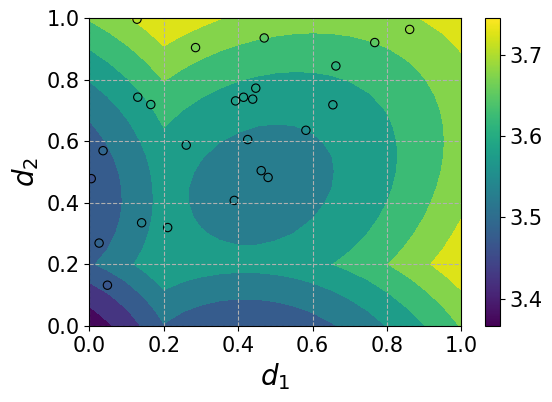

In [473]:
plt.figure(figsize=(6, 4))
plt.contourf(dX, dY, Us, vmin=Us.min(), vmax=Us.max())
sc = plt.scatter(dsr_perm[:, 0], dsr_perm[:, 1], c=Us_random, 
# sc = plt.scatter(ds_random[:, 0], ds_random[:, 1], c=Us_random, 
                 edgecolors='k',
                 linewidths=0.8,
                 vmin=Us.min(), vmax=Us.max())
plt.xlabel('$d_1$', fontsize=20)
plt.ylabel('$d_2$', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(ls='--')
cbar = plt.colorbar(sc)
cbar.ax.tick_params(labelsize=15)
plt.show()

In [474]:
import torch
import botorch

In [475]:
dx_dy_flat = np.stack((dX.flatten(), dY.flatten())).T
# dx_dy_flat

In [476]:
# Us_flat = Us.flatten()

In [477]:
from botorch.utils import standardize
from botorch.utils.transforms import normalize, unnormalize

In [478]:
import torch
from botorch.models import SingleTaskGP
from botorch.models.transforms import Normalize, Standardize
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
import copy

In [479]:
# train_x = torch.tensor(dx_dy_flat)
# train_x = torch.tensor(ds_random)
train_x = torch.tensor(dsr_perm)
# train_y_raw = torch.tensor(Us_flat).reshape(-1, 1)
train_y_raw = torch.tensor(Us_random).reshape(-1, 1)
train_y_ts = copy.deepcopy(train_y_raw)
# train_y_ts = copy.deepcopy(train_y_raw)
# train_y_std = copy.deepcopy(train_y_ts)
train_y_std = standardize(train_y_ts)
# train_y_std += 0.05 * torch.randn_like(train_y_std)

In [480]:
train_y_std.mean(), train_y_std.std()

(tensor(-5.2669e-15, dtype=torch.float64), tensor(1., dtype=torch.float64))

In [481]:
Us_random.mean()

3.571735776922505

In [482]:
train_y_ts.mean(), train_y_ts.std()

(tensor(3.5717, dtype=torch.float64), tensor(0.0643, dtype=torch.float64))

In [483]:
def phi(X):
    """Transform function phi(x) = (x1 + x2/2, |x1 - x2| / 2)"""
    x1, x2 = X[:, 0], X[:, 1]
    return torch.stack((x1 + x2 / 2, torch.abs(x1 - x2) / 2), dim=-1)

In [484]:
bounds = torch.stack([torch.zeros(2), torch.ones(2)]).to(torch.double)

In [485]:
train_x_transformed = phi(train_x)
phi_bounds = torch.stack([train_x_transformed.min() * torch.ones(2), 
                          train_x_transformed.max() * torch.ones(2)]).to(torch.double)
train_x_transformed_normalized = botorch.utils.transforms.normalize(train_x_transformed, bounds=phi_bounds)

In [486]:
# kernel_std = ScaleKernel(RBFKernel())
from gpytorch.means import ConstantMean

In [487]:
gp_regular = SingleTaskGP(
  train_X=train_x,
  train_Y=train_y_std,
  # input_transform=Normalize(d=2),
  # outcome_transform=Standardize(m=1),
  # mean_module=ConstantMean()
  # covar_module=kernel_std
)

gp_transformed = SingleTaskGP(
    train_X=train_x_transformed_normalized,
    # train_X=train_x_transformed_normalized,
    train_Y=train_y_std,
    # input_transform=Normalize(d=2),
    # outcome_transform=Standardize(m=1),
    # mean_module=ConstantMean()
    # covar_module=kernel_std
)

In [488]:
logEI1 = LogExpectedImprovement(model=gp_regular, best_f=train_y_std.max())
logEI2 = LogExpectedImprovement(model=gp_transformed, best_f=train_y_std.max())

In [489]:
candidate_regular, acq_value_regular = optimize_acqf(
  logEI1, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
)
candidate_transformed, acq_value_transformed = optimize_acqf(
  logEI2, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
)

In [490]:
candidate_regular, candidate_transformed

(tensor([[1., 1.]], dtype=torch.float64),
 tensor([[0.6373, 0.4798]], dtype=torch.float64))

In [491]:
post_regular = gp_regular.posterior
post_transformed = gp_transformed.posterior

In [492]:
dx_dy_t = torch.tensor(dx_dy_flat)
# phi_transformed_grid_normalized = botorch.utils.transforms.normalize(
                            # phi(torch.tensor(dx_dy_flat)), 
                                                                    # bounds=phi_bounds)
        
phi_transformed_grid = phi(torch.tensor(dx_dy_flat))

In [493]:
mean_regular = post_regular(dx_dy_t).mean * train_y_ts.std() + train_y_ts.mean()
std_regular = post_regular(dx_dy_t).stddev * train_y_ts.std()

# mean_regular = torch.atanh(post_regular(dx_dy_t).mean)
# std_regular = torch.atanh(post_regular(dx_dy_t).stddev)

In [494]:
mean_transformed = post_transformed(phi_transformed_grid_normalized).mean * train_y_ts.std() + train_y_ts.mean()
std_transformed = post_transformed(phi_transformed_grid_normalized).stddev * train_y_ts.std()

# mean_transformed = torch.atanh(post_transformed(phi_transformed_grid).mean)
# std_transformed = torch.atanh(post_transformed(phi_transformed_grid).stddev)

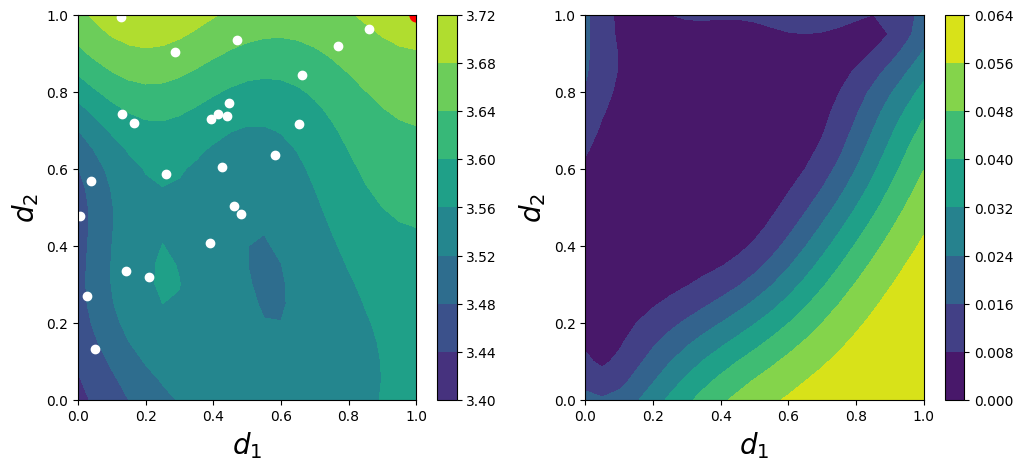

In [496]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ct0 = ax[0].contourf(dX, dY, mean_regular.detach().numpy().reshape(21, 21), 
                     vmin=Us.min(),
                     vmax=Us.max()
           )
ax[0].scatter(dsr_perm[:, 0], dsr_perm[:, 1], c='w')
# ax[0].scatter(ds_random[:, 0], ds_random[:, 1], c='w')
ax[0].scatter(candidate_regular[:, 0], candidate_regular[:, 1], s=85, c='r')

ax[0].set_xlabel('$d_1$', fontsize=20)
ax[0].set_ylabel('$d_2$', fontsize=20)
# ax[0].grid(ls='--')
fig.colorbar(ct0, ax=ax[0])


ct1 = ax[1].contourf(dX, dY, std_regular.detach().numpy().reshape(21, 21), 
           )
ax[1].set_xlabel('$d_1$', fontsize=20)
ax[1].set_ylabel('$d_2$', fontsize=20)
# ax[0].grid(ls='--')
fig.colorbar(ct1, ax=ax[1])
# plt.show()

# plt.subplot(1, 2, 2)
# plt.contourf(dX, dY, std_regular.detach().numpy().reshape(21, 21), 
#            )
# plt.xlabel('$d_1$', fontsize=20)
# plt.ylabel('$d_2$', fontsize=20)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.grid(ls='--')
# cbar = plt.colorbar()
# cbar.ax.tick_params(labelsize=15)
# plt.suptitle('GP with Untransformed Inputs')
# plt.show()

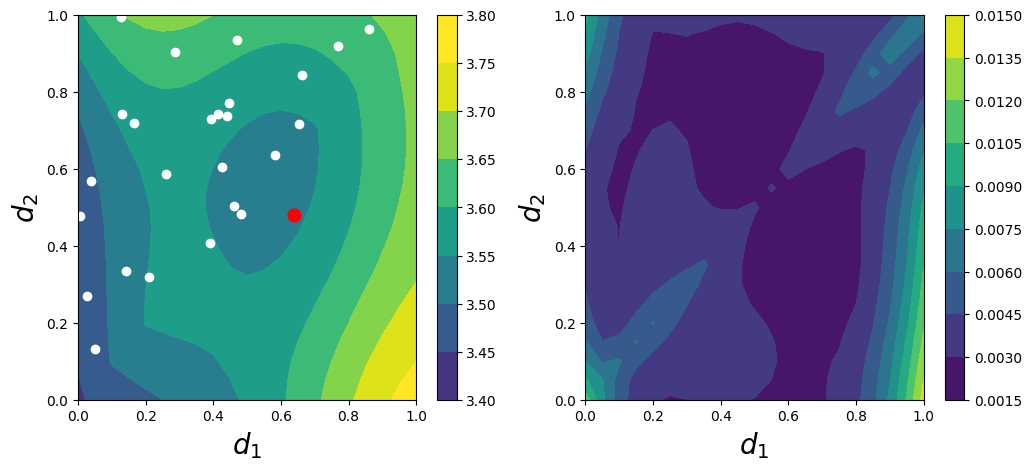

In [497]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ct0 = ax[0].contourf(dX, dY, mean_transformed.detach().numpy().reshape(21, 21), 
                     vmin=Us.min(),
                     vmax=Us.max()
           )
# ax[0].scatter(ds_random[:, 0], ds_random[:, 1], c='w')
ax[0].scatter(dsr_perm[:, 0], dsr_perm[:, 1], c='w')

ax[0].scatter(candidate_transformed[:, 0], candidate_transformed[:, 1], s=85, c='r')

ax[0].set_xlabel('$d_1$', fontsize=20)
ax[0].set_ylabel('$d_2$', fontsize=20)
# ax[0].grid(ls='--')
fig.colorbar(ct0, ax=ax[0])


ct1 = ax[1].contourf(dX, dY, std_transformed.detach().numpy().reshape(21, 21), 
           )
ax[1].set_xlabel('$d_1$', fontsize=20)
ax[1].set_ylabel('$d_2$', fontsize=20)
# ax[0].grid(ls='--')
fig.colorbar(ct1, ax=ax[1])

0.16636626070825367 0.143365546307896


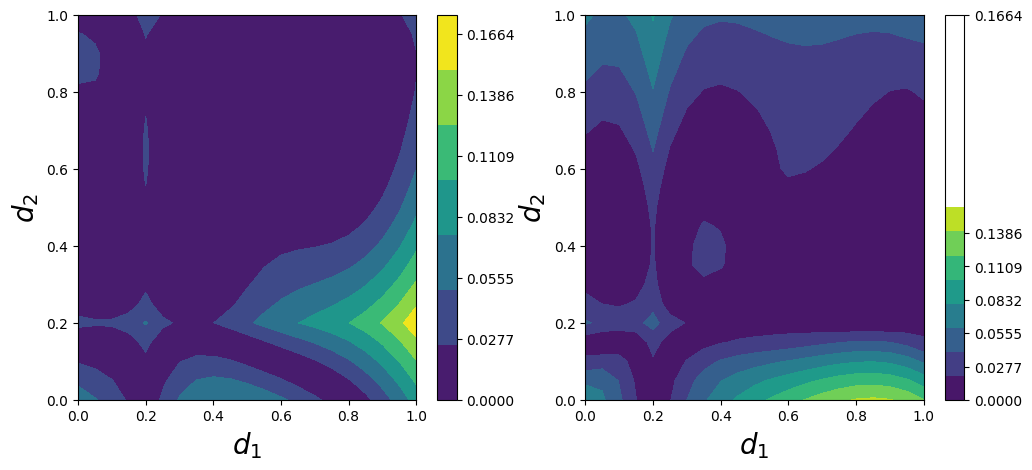

In [498]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

rmse1 = np.sqrt((Us - mean_regular.detach().numpy().reshape(21, 21))**2)
rmse2 = np.sqrt((Us - mean_transformed.detach().numpy().reshape(21, 21))**2)

rmin = min(rmse1.min(), rmse2.min())
rmax = max(rmse1.max(), rmse2.max())

print(rmse1.max(), rmse2.max())

ct0 = ax[0].contourf(dX, dY, rmse1,
                    vmin=rmin,
                    vmax=rmax)
ax[0].set_xlabel('$d_1$', fontsize=20)
ax[0].set_ylabel('$d_2$', fontsize=20)
cbar0 = fig.colorbar(ct0, ax=ax[0])
cbar0.set_ticks(np.linspace(rmin, rmax, 7))

ct1 = ax[1].contourf(dX, dY, rmse2,
                    vmin=rmin,
                    vmax=rmax)
ax[1].set_xlabel('$d_1$', fontsize=20)
ax[1].set_ylabel('$d_2$', fontsize=20)
cbar1 = fig.colorbar(ct1, ax=ax[1])
cbar1.set_ticks(np.linspace(rmin, rmax, 7))